In [55]:
import time
from datetime import datetime
from picamera import PiCamera
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imutils
import pickle
import os.path
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from googleapiclient.http import MediaFileUpload

gdfolder = '1crBqym6aiqByFbqcQn0pJkt2YRWDbVz7'
num_pictures = 10

#######################################################
# GDrive authorization
#######################################################
creds = []
SCOPES = ['https://www.googleapis.com/auth/drive.file']
if os.path.exists('token.pickle'):
    with open('token.pickle', 'rb') as token:
        creds = pickle.load(token)

if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file('credentials.json', SCOPES)
        creds = flow.run_local_server(port=0)
    
    with open('token.pickle', 'wb') as token:
        pickle.dump(creds, token)

drive = build('drive', 'v3', credentials=creds)


In [56]:
######################################################
# motion file setup
######################################################
# grab list of files that already exist
results = drive.files().list(fields="files(id, name)", q="'1crBqym6aiqByFbqcQn0pJkt2YRWDbVz7' in parents", orderBy='name').execute()['files']
gfiles = [results[ii]['id'] for ii in range(len(results)) if results[ii]['name'].startswith('motion')]

# make new placeholder files if necessary
for ii in range(len(gfiles), num_pictures):
    rc = cv2.imwrite('motion.jpg', (np.random.rand(200,300,3)*255).astype(int))
    media = MediaFileUpload('motion.jpg', mimetype='image/jpg')
    gfile = drive.files().create(body={'name': 'motion_%s.jpg' % str("{0:0=4d}".format(ii)), 'parents':[gdfolder]}, media_body=media, fields='id').execute()
    gfiles += [gfile]

In [189]:
#####################################################
# grab camera hardware and monitor
#####################################################
snapshot1 = np.empty((1024, 1280, 3), dtype=np.uint8)
snapshot2 = np.empty((1024, 1280, 3), dtype=np.uint8)
box = (190, 1280, 570, 850)
gg = 0

#fig, ax = plt.subplots(figsize=(14, 14))
#ax.imshow(background)


In [190]:
with PiCamera(resolution=(1280, 1024)) as camera:
    time.sleep(2)
    try:
        while True:  #for ii in range(num_pictures):
            
            # take two pictures separated in time
            camera.capture(snapshot1, format='bgr', use_video_port=True)
            time.sleep(0.75)
            camera.capture(snapshot2, format='bgr', use_video_port=True)
            
            start = time.time()
            
            cutout1 = np.array(snapshot1[box[2]:box[3], box[0]:box[1]])
            cutout2 = np.array(snapshot2[box[2]:box[3], box[0]:box[1]])
            
            frame1 = cv2.cvtColor(cutout1, cv2.COLOR_BGR2GRAY)
            frame1 = cv2.GaussianBlur(frame1, (31, 31), 0)
            frame2 = cv2.cvtColor(cutout2, cv2.COLOR_BGR2GRAY)
            frame2 = cv2.GaussianBlur(frame2, (31, 31), 0)
            
            # compute the difference between the current frame and running average
            frameDelta = cv2.absdiff(frame1, frame2)
            
            # threshold the delta image, dilate the thresholded image to fill in holes,
            # then find contours on thresholded image
            thresh = cv2.threshold(frameDelta, 30, 255, cv2.THRESH_BINARY)[1]
            thresh = cv2.dilate(thresh, None, iterations=5)
            cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cnts = imutils.grab_contours(cnts)
            
            # look for large contour areas
            cnts = [cc for cc in cnts if cv2.contourArea(cc) > 600]
             
            # we are looking for motion from point A to point B, this should be exactly 2 changes
            if len(cnts) == 2:
                cc = cnts[0]
                
                # compute the bounding box for the contour, draw it on the frame, and update the text
                (xx, yy, ww, hh) = cv2.boundingRect(cnts[0])
                center1 = np.array([xx + ww//2, yy + hh//2])
                rc = cv2.rectangle(cutout2, (xx, yy), (xx + ww, yy + hh), (0, 255, 0), 2)
                
                (xx, yy, ww, hh) = cv2.boundingRect(cnts[1])
                center2 = np.array([xx + ww//2, yy + hh//2])
                rc = cv2.rectangle(cutout2, (xx, yy), (xx + ww, yy + hh), (0, 255, 0), 2)
                
                distance = np.sqrt(np.sum( np.square(center1 - center2) ))
                #two_frame = np.concatenate((cutout1, np.zeros((80,cutout1.shape[1],3), dtype=int)+255, cutout2), axis=0)
                
                # blend the snapshots and add space for text annotation
                two_frame = cv2.addWeighted(cutout1, 0.5, cutout2, 0.5, 0.0)  
                two_frame = np.concatenate((two_frame, np.tile(frameDelta[...,None],3), np.tile(thresh[...,None],3), np.zeros((80,cutout1.shape[1],3), dtype=int)+255), axis=0)
                
                imtxt = datetime.now().strftime('%Y-%m-%d %H:%M:%S') + '  ' + 'distance of {:1.0f}'.format(distance)
                cv2.putText(two_frame, imtxt, (10,two_frame.shape[0]-30), cv2.FONT_HERSHEY_DUPLEX, 1, 0) 
                print('motion detected in image ' + str(gg) + '...' + imtxt, end='\r')
                
                rc = cv2.imwrite('pictures/motion' + str(gg) + '.jpg', two_frame)
                gg = (gg + 1) % num_pictures
                
                print('')
                print(time.time()-start)
                
                break
                #media = MediaFileUpload('pictures/motion' + str(gg) + '.jpg', mimetype='image/jpg')
                #gfile = drive.files().update(fileId=gfiles[gg], media_body=media).execute()
                
    except KeyboardInterrupt:
        pass


NameError: name 'twoframe' is not defined

0 255 57.57697879271373


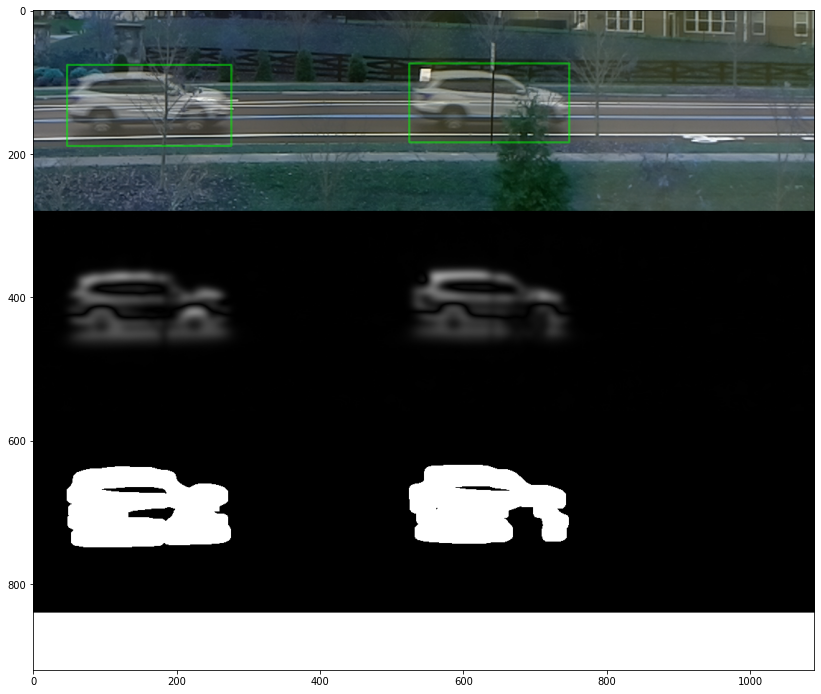

In [191]:
fig, ax = plt.subplots(figsize=(14, 14))
ax.imshow(two_frame)
print(np.min(two_frame), np.max(two_frame), np.mean(two_frame))

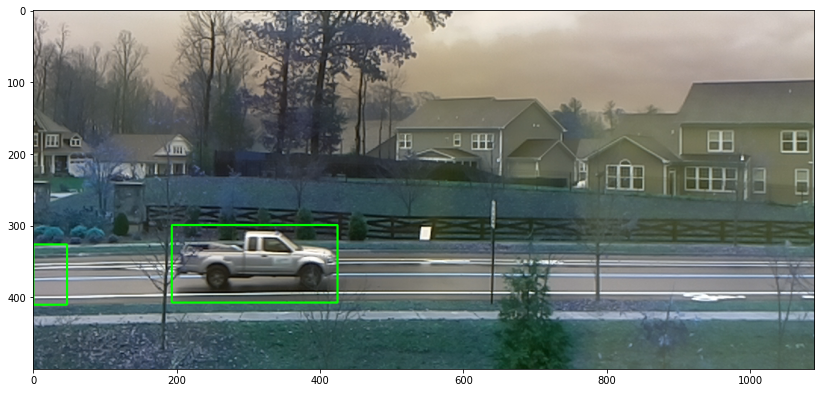

In [180]:
nfig, ax = plt.subplots(figsize=(14, 14))
ax.imshow(cutout2)

In [59]:
for ii in range(num_pictures):
    print('uploading ' + str(ii+1), end='\r')
    if os.path.exists('pictures/motion' + str(ii) + '.jpg'):
        media = MediaFileUpload('pictures/motion' + str(ii) + '.jpg', mimetype='image/jpg')
        gfile = drive.files().update(fileId=gfiles[ii], media_body=media).execute()
            